In [3]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras
from __future__ import absolute_import, division, print_function, unicode_literals

from sklearn.model_selection import KFold

from numpy.random import seed
from tensorflow.random import set_seed

import pickle
import re
import FEAT as FEAT
seed(2)

In [79]:
def get_positional_features(sequence):
    '''
    Method: fills gravy, disorder, etc. feature arrays with moving averages
            - if len(seq) < 100, pad the end with the last value 
    Input: 
        - amino acid sequence
    '''
    gravy = []
    hydrophobicity = []
    exposed = []
    disorder = []
    bulkiness = []
    interface = []
    
    sequence = re.sub('[X*]', '', sequence)
    
    to_pad = max(0, 100 - len(sequence))
    
    for ind, aa in enumerate(sequence):

        # add value to each feature array
        if aa.upper() in FEAT.INTERFACE_DIC:
            
            gravy.append( FEAT.GRAVY_DIC[aa.upper()] )
            hydrophobicity.append( FEAT.HYDRO_DIC[aa.upper()] )
            exposed.append( FEAT.EXPOSED_DIC[aa.upper()] )
            disorder.append( FEAT.DISORDER_DIC[aa.upper()] )
            bulkiness.append( FEAT.BULKY_DIC[aa.upper()] )
            interface.append( FEAT.INTERFACE_DIC[aa.upper()] )
            
        else: 
            print(aa)
            raise ValueError

    # if seq(len), then pad the end of feature array with zeros
    if to_pad > 0:
        gravy += [0] * to_pad
        hydrophobicity += [0] * to_pad
        exposed += [0] * to_pad
        disorder += [0] * to_pad
        bulkiness += [0] * to_pad
        interface += [0] * to_pad

        
    
    return(np.array(gravy), np.array(hydrophobicity), 
           np.array(exposed), np.array(disorder), 
           np.array(bulkiness), np.array(interface))

In [80]:
def get_moving_average_features(sequence):
    '''
    Method: fills gravy, disorder, etc. feature arrays with moving averages
            - if len(seq) < 100, pad the end with the last value 
    Input: 
        - amino acid sequence
    '''
    gravy = []
    hydrophobicity = []
    exposed = []
    disorder = []
    bulkiness = []
    interface = []
    
    gravy_avg = []
    hydrophobicity_avg = []
    exposed_avg = []
    disorder_avg = []
    bulkiness_avg = []
    interface_avg = []
    
    sequence = re.sub('[X*]', '', sequence)
    
    to_pad = max(0, 100 - len(sequence))
    
    for ind, aa in enumerate(sequence):

        # add value to each feature array
        if aa.upper() in FEAT.INTERFACE_DIC:
            
            gravy.append( FEAT.GRAVY_DIC[aa.upper()] )
            hydrophobicity.append( FEAT.HYDRO_DIC[aa.upper()] )
            exposed.append( FEAT.EXPOSED_DIC[aa.upper()] )
            disorder.append( FEAT.DISORDER_DIC[aa.upper()] )
            bulkiness.append( FEAT.BULKY_DIC[aa.upper()] )
            interface.append( FEAT.INTERFACE_DIC[aa.upper()] )
            
            gravy_avg.append( np.mean(gravy) )
            hydrophobicity_avg.append( np.mean(hydrophobicity) )
            exposed_avg.append( np.mean(exposed) )
            disorder_avg.append( np.mean(disorder) )
            bulkiness_avg.append( np.mean(bulkiness) )
            interface_avg.append( np.mean(interface) )
        else: 
            print(aa)
            raise ValueError

    # if seq(len), then pad the end of feature array with last val
    if to_pad > 0:
        gravy_avg += [gravy_avg[-1]] * to_pad
        hydrophobicity_avg += [hydrophobicity_avg[-1]] * to_pad
        exposed_avg += [exposed_avg[-1]] * to_pad
        disorder_avg += [disorder_avg[-1]] * to_pad
        bulkiness_avg += [bulkiness_avg[-1]] * to_pad
        interface_avg += [interface_avg[-1]] * to_pad

    
    return(np.array(gravy_avg), np.array(hydrophobicity_avg), 
           np.array(exposed_avg), np.array(disorder_avg), 
           np.array(bulkiness_avg), np.array(interface_avg))

In [81]:
def createTrainTestData(posSample, negSample, encoding='OneHot'):
    TrainTest = []
    seq_len = []
    num = []
    
    # initialize label arrays
    pos_label = np.ones( (len(posSample),1) )
    neg_label = np.zeros( (len(negSample),1) )
    Label = np.concatenate( (pos_label,neg_label), axis=0 ).flatten()
    TrainTestSample = posSample + negSample

    # create final y and x output arrays
    if encoding == 'OneHot':
        for seq in TrainTestSample:
            num = len(seq) * 20
            res = np.array(OnehotEncoding(seq)).reshape([1,num])
            TrainTest.append(res)
        
    elif encoding == 'aa_moving_averages':
        for seq in TrainTestSample:
            res = np.array(get_moving_average_features(seq))
            TrainTest.append(res)
            
    elif encoding == 'positional':
        for seq in TrainTestSample:
            res = np.array(get_positional_features(seq))
            TrainTest.append(res)
        
    TrainTest = np.array(TrainTest).reshape( len(TrainTestSample), 100, 6 )
    print(np.array(TrainTest).shape)


    return Label, TrainTest

In [82]:
def readFile(inpFile,maxlen):
    _hash={}
    _seq=[]

    for line in open(inpFile):
        if line.startswith('>'):
            name=line.replace('>','').split()[0]
            _hash[name] = ''
        else:
            _hash[name] += line.replace('\n','')

    for i in _hash.keys():
        if len(_hash[i]) <= maxlen:
            Proseq = _hash[i] + "X" * (maxlen - len(_hash[i]))
        else:
            Proseq = _hash[i][0:maxlen]
        _seq.append(Proseq)

    return _seq

In [84]:
pos_Train = readFile("20190512_positives.fasta", 100)
neg_Train = readFile("20190512_negatives.fasta", 100)

# custom function to provide encoding
y_train, x_train = createTrainTestData(pos_Train, neg_Train, encoding='positional')

# shuffle so positives and negatives aren't bunched together
shuffle_indices = np.arange(len(y_train))
np.random.shuffle(shuffle_indices)

### SHUFFLING
x_train = x_train[shuffle_indices, :]
y_train = y_train[shuffle_indices]

# get ready for CNN input, make target y categorical
x_train = x_train.reshape(x_train.shape[0], 100, 6)
y_train = tf.keras.utils.to_categorical(y_train, 2)

print(x_train.shape)
print(y_train.shape)

(184, 100, 6)
(184, 100, 6)
(184, 2)


In [72]:
import matplotlib.pyplot as plt

def plotter(history):
    
    print("final epoch's metrics ~ ")
    for key in history.history.keys():
        print("\t", key, " : ", history.history[key][-1])
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## (high accuracy) ecoding using moving averages

In [ ]:
# build CNN model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(650, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0)

final epoch's metrics ~ 
	 loss  :  0.1391123940243202
	 accuracy  :  0.9319728
	 val_loss  :  0.23214466346276774
	 val_accuracy  :  0.8648649


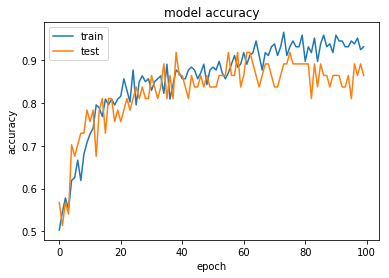

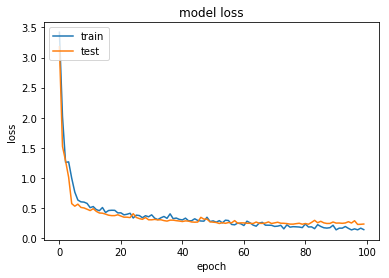

In [171]:
plotter(history)

In [173]:
model.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_139 (Conv1D)          (None, 91, 32)            1952      
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 45, 32)            0         
_________________________________________________________________
flatten_58 (Flatten)         (None, 1440)              0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 1440)              0         
_________________________________________________________________
dense_128 (Dense)            (None, 650)               936650    
_________________________________________________________________
dropout_130 (Dropout)        (None, 650)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 2)               

## (lower accuracy) 200aa moving averages encoding

final epoch's metrics ~ 
	 loss  :  0.053462277920473186
	 accuracy  :  0.99319726
	 val_loss  :  0.2878454939739124
	 val_accuracy  :  0.8378378


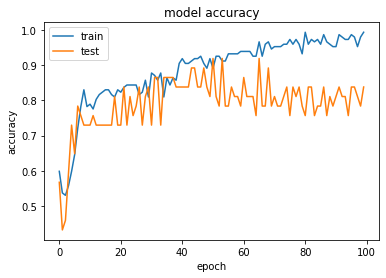

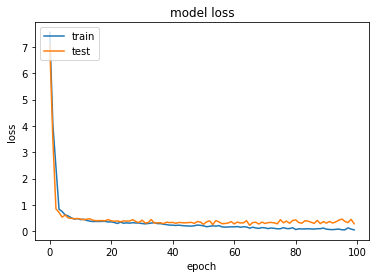

In [60]:
# build CNN model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(200,6)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(650, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0)
plotter(history)

## (low accuracy) encoding positional values instead of moving averages

In [18]:
# build CNN model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(650, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0)

final epoch's metrics ~ 
	 loss  :  0.01307146349164727
	 accuracy  :  1.0
	 val_loss  :  1.1411658171060923
	 val_accuracy  :  0.7567568


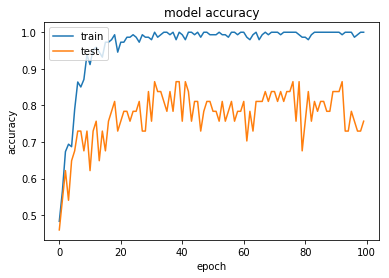

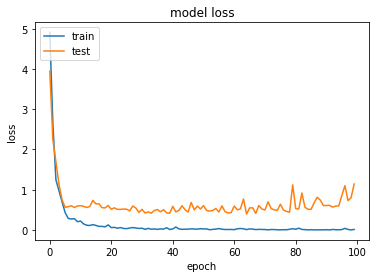

In [19]:
plotter(history)

In [154]:
# build CNN model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Conv1D(32, kernel_size=(6),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(555, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=40, validation_split=0.2)

Train on 147 samples, validate on 37 samples
Epoch 1/40
147/147 [==============================] - 0s 3ms/sample - loss: 3.6648 - accuracy: 0.4966 - val_loss: 2.6547 - val_accuracy: 0.4324
Epoch 2/40
147/147 [==============================] - 0s 607us/sample - loss: 1.3784 - accuracy: 0.5034 - val_loss: 0.8740 - val_accuracy: 0.5676
Epoch 3/40
147/147 [==============================] - 0s 576us/sample - loss: 0.7892 - accuracy: 0.5170 - val_loss: 0.7819 - val_accuracy: 0.4324
Epoch 4/40
147/147 [==============================] - 0s 530us/sample - loss: 0.7019 - accuracy: 0.5170 - val_loss: 0.7573 - val_accuracy: 0.7027
Epoch 5/40
147/147 [==============================] - 0s 586us/sample - loss: 0.6448 - accuracy: 0.5986 - val_loss: 0.7648 - val_accuracy: 0.6216
Epoch 6/40
147/147 [==============================] - 0s 529us/sample - loss: 0.5953 - accuracy: 0.6939 - val_loss: 0.8581 - val_accuracy: 0.7838
Epoch 7/40
147/147 [==============================] - 0s 634us/sample - loss: 0.5

final epoch's metrics ~ 
	 loss  :  0.20456289809171846
	 accuracy  :  0.93877554
	 val_loss  :  0.6459722067858722
	 val_accuracy  :  0.7837838


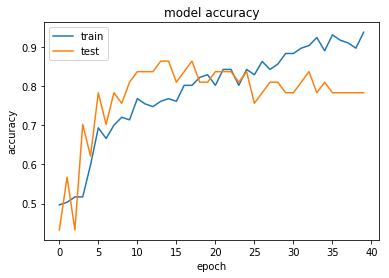

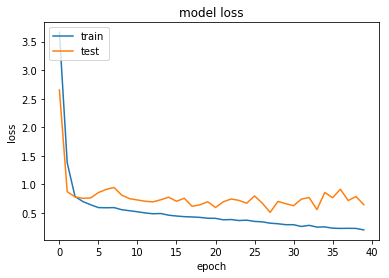

In [155]:
plotter(history)

### PRETTY GOOD

In [156]:
# build CNN model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Conv1D(16, kernel_size=(4),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(650, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=50, validation_split=0.3)

Train on 128 samples, validate on 56 samples
Epoch 1/50
128/128 [==============================] - 0s 3ms/sample - loss: 2.5107 - accuracy: 0.4297 - val_loss: 1.3578 - val_accuracy: 0.4286
Epoch 2/50
128/128 [==============================] - 0s 420us/sample - loss: 1.0291 - accuracy: 0.5938 - val_loss: 0.6766 - val_accuracy: 0.5536
Epoch 3/50
128/128 [==============================] - 0s 380us/sample - loss: 1.0029 - accuracy: 0.4375 - val_loss: 0.6804 - val_accuracy: 0.5357
Epoch 4/50
128/128 [==============================] - 0s 361us/sample - loss: 0.7494 - accuracy: 0.5781 - val_loss: 0.8514 - val_accuracy: 0.4286
Epoch 5/50
128/128 [==============================] - 0s 381us/sample - loss: 0.7194 - accuracy: 0.5625 - val_loss: 0.6900 - val_accuracy: 0.5714
Epoch 6/50
128/128 [==============================] - 0s 356us/sample - loss: 0.7169 - accuracy: 0.5625 - val_loss: 0.6950 - val_accuracy: 0.6786
Epoch 7/50
128/128 [==============================] - 0s 389us/sample - loss: 0.6

final epoch's metrics ~ 
	 loss  :  0.24293944984674454
	 accuracy  :  0.921875
	 val_loss  :  0.5065682785851615
	 val_accuracy  :  0.8035714


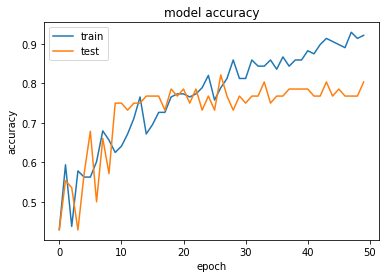

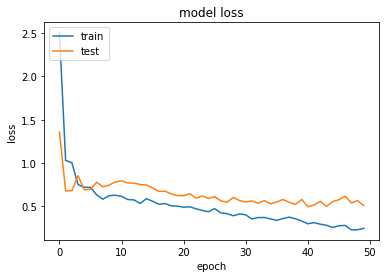

In [157]:
plotter(history)

In [104]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           (None, 91, 32)            1952      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 45, 32)            0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 42, 16)            2064      
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 21, 16)            0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 336)               0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 336)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 650)             

### website keras 1d implementation (meh)
https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

In [118]:
model_m = models.Sequential()

model_m.add(layers.Conv1D(100, 10, activation='relu', input_shape=(100,6)))
model_m.add(layers.Conv1D(100, 10, activation='relu'))
model_m.add(layers.MaxPooling1D(3))
model_m.add(layers.Conv1D(160, 5, activation='relu'))
model_m.add(layers.Conv1D(160, 5, activation='relu'))
model_m.add(layers.GlobalAveragePooling1D())
model_m.add(layers.Dropout(0.3))
model_m.add(layers.Dense(2, activation='softmax'))

model_m.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])



model_m.fit(x_train, y_train, epochs=50, validation_split=0.2)


Train on 147 samples, validate on 37 samples
Epoch 1/50
147/147 [==============================] - 1s 5ms/sample - loss: 1.1987 - accuracy: 0.5170 - val_loss: 0.8771 - val_accuracy: 0.4324
Epoch 2/50
147/147 [==============================] - 0s 1ms/sample - loss: 0.7251 - accuracy: 0.5170 - val_loss: 0.6850 - val_accuracy: 0.5676
Epoch 3/50
147/147 [==============================] - 0s 1ms/sample - loss: 0.6917 - accuracy: 0.4558 - val_loss: 0.7100 - val_accuracy: 0.4324
Epoch 4/50
147/147 [==============================] - 0s 1ms/sample - loss: 0.6942 - accuracy: 0.5102 - val_loss: 0.7181 - val_accuracy: 0.4324
Epoch 5/50
147/147 [==============================] - 0s 1ms/sample - loss: 0.6640 - accuracy: 0.5442 - val_loss: 0.7533 - val_accuracy: 0.6757
Epoch 6/50
147/147 [==============================] - 0s 1ms/sample - loss: 0.6449 - accuracy: 0.5782 - val_loss: 0.8091 - val_accuracy: 0.7027
Epoch 7/50
147/147 [==============================] - 0s 1ms/sample - loss: 0.6311 - accura

## cross val

In [62]:
x_p = open('20190528_x.pckl', 'rb')
y_p = open('20190528_y.pckl', 'rb')

x_straw = pickle.load(x_p)
y_straw = pickle.load(y_p)

x_p.close()
y_p.close()

from strawman import my_logistic_regression

## with more aa's

In [63]:
kf = KFold(n_splits=5, random_state=2, shuffle=True)

# initialize acc arrays
accuracies = []
cnn_accuracies = []

xtrain = x_train.copy()
ytrain = y_train.copy()

iteration = 1
for train_index, test_index in kf.split(x_straw):
    
    # get training/testing indices
    cnn_x_train, cnn_x_test = x_train[train_index], x_train[test_index]
    cnn_y_train, cnn_y_test = y_train[train_index], y_train[test_index]

    X_train, X_test = x_straw[train_index], x_straw[test_index]
    Y_train, y_test = y_straw[train_index], y_straw[test_index]
    
    # normalize each strawman cross validation k fold train/test features
    X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
    X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
    
### LOGISTIC REGRESSION (strawman) CROSS VALIDATION

    # initialize model, fit on training split, predict on testing data
    straw_model = my_logistic_regression()
    straw_model.fit(X_train, Y_train, nsteps=10000, alpha_learning_rate=5e-5)
    predictions = straw_model.predict(X_test)

    # get accuracy for k-fold
    k_accuracy = np.equal(predictions,y_test).sum().astype(float) / len(predictions)
    accuracies.append(k_accuracy)
    print("accuracy for strawman k-fold", iteration, ":", np.round(k_accuracy * 100, 2), "%")
    
### CONV NET CROSS VALIDATION

    # build CNN model
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(200,6)))
    model.add(layers.MaxPooling1D(pool_size=(2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(650, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])



    # fit on fold's training set, test on fold's testing set 
    model.fit(cnn_x_train, cnn_y_train, epochs=100, verbose=0)

    # obtain output
    predictions = model.predict(cnn_x_test)
    
    # output is one-hot encoded 2d array, so get a 1d array to get accuracy
    
    pred_classes = []
    for pair in predictions:
        if pair[0] > pair[1]:
            pred_classes.append(0)
        else:
            pred_classes.append(1)
    
    cnn_y_new = []
    for pair in cnn_y_test:
        if pair[0] > pair[1]:
            cnn_y_new.append(0)
        else:
            cnn_y_new.append(1)
            
    # get accuracy for cnn k-fold, append to k-fold accuracy array
    k_accuracy = np.equal(pred_classes, cnn_y_new).sum().astype(float) / len(pred_classes)
    
    cnn_accuracies.append(k_accuracy)
    print("accuracy for    cnn   k-fold", iteration, ":", np.round(k_accuracy * 100, 2), "%")
    iteration +=1


    
print("\naverage strawman accuracy from 5 cross validation folds: ", 
      np.round(np.mean(accuracies) * 100, decimals=2), "%")

print("\naverage    cnn   accuracy from 5 cross validation folds: ", 
      np.round(np.mean(cnn_accuracies) * 100, decimals=2), "%")

accuracy for strawman k-fold 1 : 86.49 %
accuracy for    cnn   k-fold 1 : 78.38 %
accuracy for strawman k-fold 2 : 81.08 %
accuracy for    cnn   k-fold 2 : 89.19 %
accuracy for strawman k-fold 3 : 83.78 %
accuracy for    cnn   k-fold 3 : 86.49 %
accuracy for strawman k-fold 4 : 83.78 %
accuracy for    cnn   k-fold 4 : 83.78 %
accuracy for strawman k-fold 5 : 86.11 %
accuracy for    cnn   k-fold 5 : 80.56 %

average strawman accuracy from 5 cross validation folds:  84.25 %

average    cnn   accuracy from 5 cross validation folds:  83.68 %


In [85]:
kf = KFold(n_splits=5, random_state=2, shuffle=True)

# initialize acc arrays
accuracies = []
cnn_accuracies = []

xtrain = x_train.copy()
ytrain = y_train.copy()

iteration = 1
for train_index, test_index in kf.split(x_straw):
    
    # get training/testing indices
    cnn_x_train, cnn_x_test = x_train[train_index], x_train[test_index]
    cnn_y_train, cnn_y_test = y_train[train_index], y_train[test_index]

    X_train, X_test = x_straw[train_index], x_straw[test_index]
    Y_train, y_test = y_straw[train_index], y_straw[test_index]
    
    # normalize each strawman cross validation k fold train/test features
    X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
    X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
    
### LOGISTIC REGRESSION (strawman) CROSS VALIDATION

    # initialize model, fit on training split, predict on testing data
    straw_model = my_logistic_regression()
    straw_model.fit(X_train, Y_train, nsteps=10000, alpha_learning_rate=5e-5)
    predictions = straw_model.predict(X_test)

    # get accuracy for k-fold
    k_accuracy = np.equal(predictions,y_test).sum().astype(float) / len(predictions)
    accuracies.append(k_accuracy)
    print("accuracy for strawman k-fold", iteration, ":", np.round(k_accuracy * 100, 2), "%")
    
### CONV NET CROSS VALIDATION

    # build CNN model
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
    model.add(layers.MaxPooling1D(pool_size=(2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(650, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])



    # fit on fold's training set, test on fold's testing set 
    model.fit(cnn_x_train, cnn_y_train, epochs=100, verbose=0)

    # obtain output
    predictions = model.predict(cnn_x_test)
    
    # output is one-hot encoded 2d array, so get a 1d array to get accuracy
    
    pred_classes = []
    for pair in predictions:
        if pair[0] > pair[1]:
            pred_classes.append(0)
        else:
            pred_classes.append(1)
    
    cnn_y_new = []
    for pair in cnn_y_test:
        if pair[0] > pair[1]:
            cnn_y_new.append(0)
        else:
            cnn_y_new.append(1)
            
    # get accuracy for cnn k-fold, append to k-fold accuracy array
    k_accuracy = np.equal(pred_classes, cnn_y_new).sum().astype(float) / len(pred_classes)
    
    cnn_accuracies.append(k_accuracy)
    print("accuracy for    cnn   k-fold", iteration, ":", np.round(k_accuracy * 100, 2), "%")
    iteration +=1


    
print("\naverage strawman accuracy from 5 cross validation folds: ", 
      np.round(np.mean(accuracies) * 100, decimals=2), "%")

print("\naverage    cnn   accuracy from 5 cross validation folds: ", 
      np.round(np.mean(cnn_accuracies) * 100, decimals=2), "%")

accuracy for strawman k-fold 1 : 86.49 %
accuracy for    cnn   k-fold 1 : 75.68 %
accuracy for strawman k-fold 2 : 81.08 %
accuracy for    cnn   k-fold 2 : 62.16 %
accuracy for strawman k-fold 3 : 83.78 %
accuracy for    cnn   k-fold 3 : 72.97 %
accuracy for strawman k-fold 4 : 83.78 %
accuracy for    cnn   k-fold 4 : 75.68 %
accuracy for strawman k-fold 5 : 86.11 %
accuracy for    cnn   k-fold 5 : 72.22 %

average strawman accuracy from 5 cross validation folds:  84.25 %

average    cnn   accuracy from 5 cross validation folds:  71.74 %


## keras website cnn

In [181]:
kf = KFold(n_splits=5, random_state=2, shuffle=True)

# initialize acc arrays
accuracies = []
cnn_accuracies = []

xtrain = x_train.copy()
ytrain = y_train.copy()

iteration = 1
for train_index, test_index in kf.split(x_straw):
    
    # get training/testing indices
    cnn_x_train, cnn_x_test = x_train[train_index], x_train[test_index]
    cnn_y_train, cnn_y_test = y_train[train_index], y_train[test_index]

    X_train, X_test = x_straw[train_index], x_straw[test_index]
    Y_train, y_test = y_straw[train_index], y_straw[test_index]
    
    # normalize each strawman cross validation k fold train/test features
    X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
    X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
    
### LOGISTIC REGRESSION (strawman) CROSS VALIDATION

    # initialize model, fit on training split, predict on testing data
    straw_model = my_logistic_regression()
    straw_model.fit(X_train, Y_train, nsteps=10000, alpha_learning_rate=5e-5)
    predictions = straw_model.predict(X_test)

    # get accuracy for k-fold
    k_accuracy = np.equal(predictions,y_test).sum().astype(float) / len(predictions)
    accuracies.append(k_accuracy)
    print("accuracy for strawman k-fold", iteration, ":", np.round(k_accuracy * 100, 2), "%")
    
### CONV NET CROSS VALIDATION

    model = models.Sequential()

    model.add(layers.Conv1D(100, 10, activation='relu', input_shape=(100,6)))
    model.add(layers.Conv1D(100, 10, activation='relu'))
    model.add(layers.MaxPooling1D(3))
    model.add(layers.Conv1D(160, 5, activation='relu'))
    model.add(layers.Conv1D(160, 5, activation='relu'))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


    # fit on fold's training set, test on fold's testing set 
    model.fit(cnn_x_train, cnn_y_train, epochs=100, verbose=0)

    # obtain output
    predictions = model.predict(cnn_x_test)
    
    # output is one-hot encoded 2d array, so get a 1d array to get accuracy
    
    pred_classes = []
    for pair in predictions:
        if pair[0] > pair[1]:
            pred_classes.append(0)
        else:
            pred_classes.append(1)
    
    cnn_y_new = []
    for pair in cnn_y_test:
        if pair[0] > pair[1]:
            cnn_y_new.append(0)
        else:
            cnn_y_new.append(1)
            
    # get accuracy for cnn k-fold, append to k-fold accuracy array
    k_accuracy = np.equal(pred_classes, cnn_y_new).sum().astype(float) / len(pred_classes)
    
    cnn_accuracies.append(k_accuracy)
    print("accuracy for    cnn   k-fold", iteration, ":", np.round(k_accuracy * 100, 2), "%")
    iteration +=1


    
print("\naverage strawman accuracy from 5 cross validation folds: ", 
      np.round(np.mean(accuracies) * 100, decimals=2), "%")

print("\naverage    cnn   accuracy from 5 cross validation folds: ", 
      np.round(np.mean(cnn_accuracies) * 100, decimals=2), "%")

accuracy for strawman k-fold 1 : 86.49 %
accuracy for    cnn   k-fold 1 : 91.89 %
accuracy for strawman k-fold 2 : 81.08 %
accuracy for    cnn   k-fold 2 : 91.89 %
accuracy for strawman k-fold 3 : 83.78 %
accuracy for    cnn   k-fold 3 : 81.08 %
accuracy for strawman k-fold 4 : 83.78 %
accuracy for    cnn   k-fold 4 : 72.97 %
accuracy for strawman k-fold 5 : 86.11 %
accuracy for    cnn   k-fold 5 : 83.33 %

average strawman accuracy from 5 cross validation folds:  84.25 %

average    cnn   accuracy from 5 cross validation folds:  84.23 %


## pretty good one (but first might be best)

In [74]:
kf = KFold(n_splits=5, random_state=2, shuffle=True)

# initialize acc arrays
accuracies = []
cnn_accuracies = []

xtrain = x_train.copy()
ytrain = y_train.copy()

iteration = 1
for train_index, test_index in kf.split(x_straw):
    
    # get training/testing indices
    cnn_x_train, cnn_x_test = x_train[train_index], x_train[test_index]
    cnn_y_train, cnn_y_test = y_train[train_index], y_train[test_index]

    X_train, X_test = x_straw[train_index], x_straw[test_index]
    Y_train, y_test = y_straw[train_index], y_straw[test_index]
    
    # normalize each strawman cross validation k fold train/test features
    X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
    X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
    
### LOGISTIC REGRESSION (strawman) CROSS VALIDATION

    # initialize model, fit on training split, predict on testing data
    straw_model = my_logistic_regression()
    straw_model.fit(X_train, Y_train, nsteps=10000, alpha_learning_rate=5e-5)
    predictions = straw_model.predict(X_test)

    # get accuracy for k-fold
    k_accuracy = np.equal(predictions,y_test).sum().astype(float) / len(predictions)
    accuracies.append(k_accuracy)
    print("accuracy for strawman k-fold", iteration, ":", np.round(k_accuracy * 100, 2), "%")
    
### CONV NET CROSS VALIDATION

    # build CNN model
    model = models.Sequential()
    model.add(layers.Conv1D(100, 10, activation='relu', input_shape=(100,6)))
    model.add(layers.Conv1D(100, 10, activation='relu'))
    model.add(layers.MaxPooling1D(3))
    model.add(layers.Conv1D(160, 5, activation='relu'))
    model.add(layers.Conv1D(160, 5, activation='relu'))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


    # fit on fold's training set, test on fold's testing set 
    model.fit(cnn_x_train, cnn_y_train, epochs=100, verbose=0)

    # obtain output
    predictions = model.predict(cnn_x_test)
    
    # output is one-hot encoded 2d array, so get a 1d array to get accuracy
    
    pred_classes = []
    for pair in predictions:
        if pair[0] > pair[1]:
            pred_classes.append(0)
        else:
            pred_classes.append(1)
    
    cnn_y_new = []
    for pair in cnn_y_test:
        if pair[0] > pair[1]:
            cnn_y_new.append(0)
        else:
            cnn_y_new.append(1)
            
    # get accuracy for cnn k-fold, append to k-fold accuracy array
    k_accuracy = np.equal(pred_classes, cnn_y_new).sum().astype(float) / len(pred_classes)
    
    cnn_accuracies.append(k_accuracy)
    print("accuracy for    cnn   k-fold", iteration, ":", np.round(k_accuracy * 100, 2), "%")
    iteration +=1


    
print("\naverage strawman accuracy from 5 cross validation folds: ", 
      np.round(np.mean(accuracies) * 100, decimals=2), "%")

print("\naverage    cnn   accuracy from 5 cross validation folds: ", 
      np.round(np.mean(cnn_accuracies) * 100, decimals=2), "%")

accuracy for strawman k-fold 1 : 86.49 %
accuracy for    cnn   k-fold 1 : 72.97 %
accuracy for strawman k-fold 2 : 81.08 %
accuracy for    cnn   k-fold 2 : 83.78 %
accuracy for strawman k-fold 3 : 83.78 %
accuracy for    cnn   k-fold 3 : 70.27 %
accuracy for strawman k-fold 4 : 83.78 %
accuracy for    cnn   k-fold 4 : 72.97 %
accuracy for strawman k-fold 5 : 86.11 %
accuracy for    cnn   k-fold 5 : 69.44 %

average strawman accuracy from 5 cross validation folds:  84.25 %

average    cnn   accuracy from 5 cross validation folds:  73.89 %


## (unsuccessful) feature extraction

final epoch's metrics ~ 
	 loss  :  0.16426912486097034
	 accuracy  :  0.93877554
	 val_loss  :  0.4494390244016776
	 val_accuracy  :  0.8378378


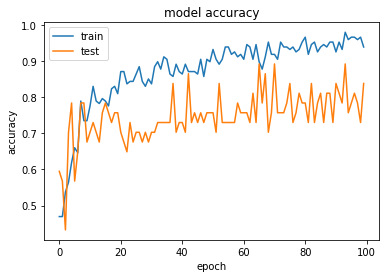

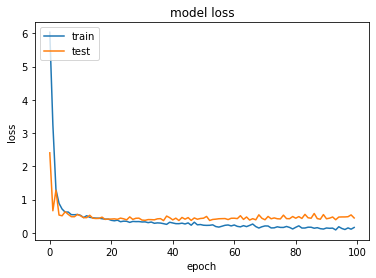

In [13]:
# build CNN model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=(10),activation='relu', input_shape=(100,6)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(650, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0)
plotter(history)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 91, 32)            1952      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 45, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1440)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 650)               936650    
_________________________________________________________________
dropout_5 (Dropout)          (None, 650)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [33]:
from vis.visualization import visualize_cam
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

layer_idx = utils.find_layer_idx(model, 'dense_5')
layer_idx

6

In [ ]:
for class_idx in np.arange(2):    
    indices = np.where(y_train[:, class_idx] == 1.)[0]
    idx = indices[0]

# Swap softmax with linear
#model.layers[layer_idx].activation = activations.linear
#model = utils.apply_modifications(model)
grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=x_train[idx], backprop_modifier=None, penultimate_layer_idx=1)  

#grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_train[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

In [ ]:
# This corresponds to the Dense linear layer.
for class_idx in np.arange(2):    
    indices = np.where(y_train[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_train[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=x_test[idx], backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')